In [1]:
import numpy as np
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, N_syl, N_HVC_per_syl = 600, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 10 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

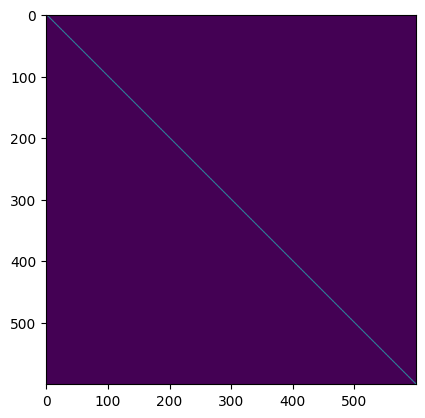

In [5]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
syl_cov = np.zeros((NE,NE))
K = 1
for i in range(NE//K):
    syl_cov[K*i:K*(i+1),K*i:K*(i+1)] = 2.5
syl_cov[np.arange(NE),np.arange(NE)] = 3
plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
# plt.plot(rH[:T_rend+T_burn])
# plt.plot(tsyl_start[:,0], np.zeros(N_syl) + peak_rate, 'x', c='r')
# plt.plot(tsyl_end[:,0], np.zeros(N_syl) + peak_rate, 'x', c='b')
# plt.plot(burst_ts[:,0], np.zeros(N_HVC) + peak_rate, '|', c='k')

In [8]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [9]:
r_rest = 1 # target rate when phi(0)
rmax, s = 40, 2
th = -erfinv(r_rest * 2 / rmax - 1) * (np.sqrt(2) * s)
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [10]:
def bilin_hebb(net, aiv, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * (aiv - 1) * h - (net.W[:,i] - w0_mean)
        net.W[:,i] = np.clip(net.W[:,i] + dW / tauW, a_min=0, a_max=None)

In [11]:
w0_mean = 1/N_HVC
w_inh = w0_mean
tauE, dt = 40, 1

net = WCNet(NE, N_HVC, w0_mean, phi, tauE, w_inh=w_inh)

rE0 = r_rest
_ = net.sim(rE0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
            lr=-5e-2, w0_mean=w0_mean, tauW=1e5)
rE, _, Ws, mean_HVC_input = _

Not a recurrent model and rI will not be calculated.


100%|█████████████████████████████████████| 6499/6499 [00:02<00:00, 2662.01it/s]


(<Figure size 400x450 with 3 Axes>,
 array([<Axes: ylabel='$\\left\\langle \\| W \\|_F \\right\\rangle$'>,
        <Axes: ylabel='mean input\nfrom HVC'>,
        <Axes: xlabel='Time (a.u.)', ylabel='Mean exc. rate'>],
       dtype=object))

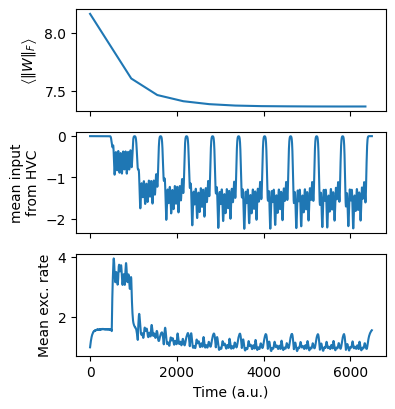

In [12]:
plot_train_stats(Ws, rE, mean_HVC_input, save_W_ts)

In [13]:
W_syl_corrs = [correlation(_.T, syl, dim=2) for _ in Ws]

(<Figure size 600x200 with 4 Axes>,
 array([<Axes: title={'center': 'Rendition 0'}, ylabel='HVC index'>,
        <Axes: title={'center': 'Rendition 5'}>,
        <Axes: title={'center': 'Rendition 10'}>], dtype=object))

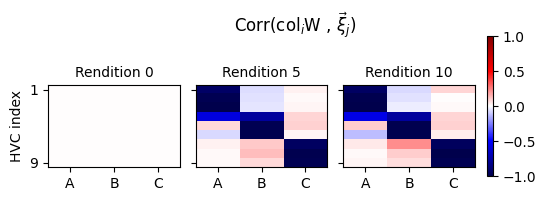

In [14]:
plot_wcol_corr(W_syl_corrs, (1, 3), (6, 2))

(<Figure size 400x450 with 3 Axes>,
 array([<Axes: ylabel='$\\left\\langle |\\Delta W_{ij}|\\right\\rangle_i$'>,
        <Axes: ylabel='weight corr.\nabs. change'>,
        <Axes: ylabel='$\\left\\langle |r^E - r^E_0| \\right\\rangle$'>],
       dtype=object))

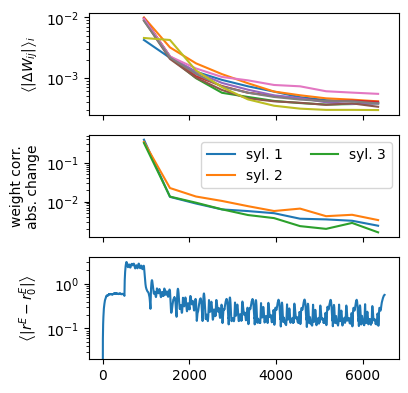

In [15]:
plot_train_converge(Ws, W_syl_corrs, save_W_ts, rE, r_rest)

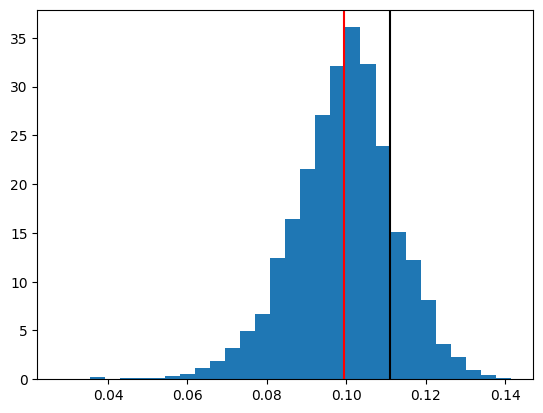

In [16]:
plt.hist(Ws[-1].flatten(), density=True, bins=30)
plt.axvline(Ws[-1].mean(), color='r')
plt.axvline(w0_mean, color='k')

## Test Model with Unmatched Auditory Feedback

### Mismatch with completely independent patterns

In [17]:
exp = Experiment(net, rH, syl, noise=1, T_test=T_burn+T_rend, 
                 t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
pert_mean = np.ones(NE)
pert_cov, K = np.zeros((NE,NE)), 1
if K > 1:
    for i in range(NE//K):
        pert_cov[K*i:K*(i+1),K*i:K*(i+1)] = 7.5
pert_cov[np.arange(NE),np.arange(NE)] = 9
pert_args = [(pert_mean, pert_cov, 0)]
# K = 10
# pert_mean = np.zeros(NE)
# pert_mean[:K] = 2
# pert_cov = np.zeros((NE,NE))
# pert_cov[np.arange(NE),np.arange(NE)] = 1
# pert = rng.multivariate_normal(pert_mean, pert_cov, size=N_syl)
# pert_args = [(pert, 1)]
test_codes = ('correct', 'perturb', 'off', 'correct') # last one for playback
if_sing = (True, True, True, False)
test_names = ('Singing\ncorrect', 'Singing\nperturb',
              'Singing\ndeafen', 'Playback\n')
tests_all = exp.sim_multi(test_codes, if_sing, pert_args * len(test_codes))

100%|████████████████████████████████████| 1099/1099 [00:00<00:00, 14307.26it/s]


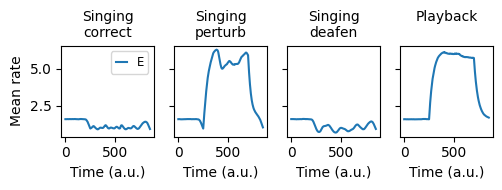

In [18]:
ti, tj = T_burn//2, T_burn + T_rend
fig, ax = plot_tests_mean(tests_all[0], test_names, ti, tj, plot_inh=False)

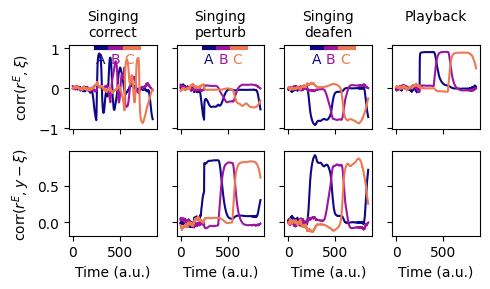

In [19]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all[2][1])] # for index-shuffled
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs(tests_all[0], tests_all[1], syl, test_names,
                           ti, tj, tid_perturb_input=(1, 2), 
                           syl_order=so, y=1)

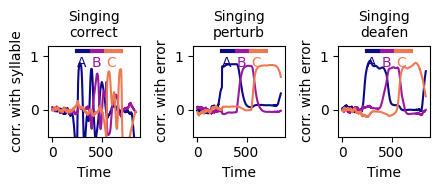

In [20]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all[2][1])] # for index-shuffled
# Do not need to show playback
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs_simple(tests_all[0][:-1], tests_all[1][:-1], syl, test_names[:-1],
                           ti, tj, tid_perturb_input=(1, 2), 
                           syl_order=so, y=1.1)

0 600


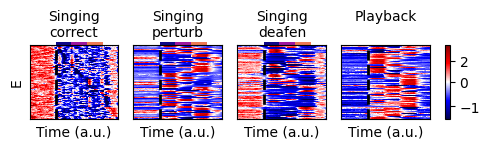

In [21]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
fig, ax = plot_tests_raster(tests_all[0], test_names, ti, tj, T_burn, plot_inh=False, 
                            syl_order=so)
fig.savefig('raster_FF.svg')

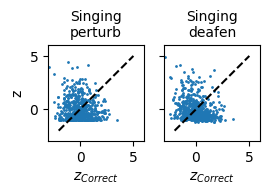

In [22]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_ctrl_vs_nonctrl(tests_all[0][:-1], test_names[:-1], ti, tj)
fig.savefig('joint_dist_c_vs_nc_FF.svg')

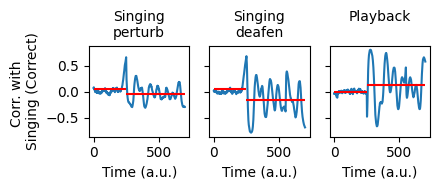

In [23]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_corr_ctrl_nonctrl(tests_all[0], test_names, ti, tj, T_burn)

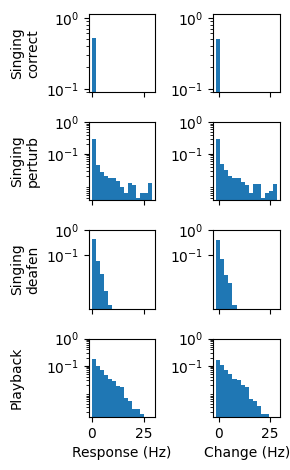

In [24]:
ti, tj = T_burn, int(tsyl_end[0,0])
fig, ax = plot_rate_and_change_dists(tests_all[0], test_names, tests_all[0][0], ti, tj)

In [36]:
def plot_rate_and_change_dists(tests, test_names, ctrl, ti, tj):
    ''' Histograms of rates and rate changes
    '''
    ls = [t[0][ti:tj].mean(axis=0) for t in tests]
    ctrl_mean = ctrl[0][ti:tj].mean(axis=0)
    changes = [l - ctrl_mean for l in ls]
    lmax = max(list(map(lambda _: _.max(), ls)))
    cmax = max(list(map(lambda _: _.max(), changes)))
    cmin = min(list(map(lambda _: _.min(), changes)))
    fig, ax = plt.subplots(len(ls), 2, figsize=(3, 1.2*len(tests)), 
                           sharex='col')
    if len(ls) == 1:
        ax = ax[None,:]
    for i, (l, c, k) in enumerate(zip(ls, changes, test_names)):
        ax[i,0].hist(l, bins=15, range=(0, 15), density=True, log=True)
        ax[i,0].set_ylabel(k, fontsize=10)
        ax[i,1].hist(c, bins=15, range=(-5, 15), density=True, log=True)
        for j in (0, 1):
            ax[i,j].set(yticks=[0.1, 1])
    ax[-1,0].set(xlabel='Response (Hz)')
    ax[-1,1].set(xlabel='Change (Hz)')
    fig.tight_layout()
    return fig, ax

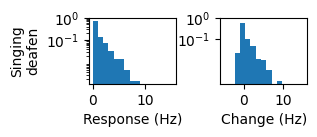

In [37]:
ti, tj = T_burn, int(tsyl_end[0,0])
fig, ax = plot_rate_and_change_dists(tests_all[0][2:3], test_names[2:3], tests_all[0][0], ti, tj)
fig.tight_layout(pad=0.1)
fig.savefig('change_deafen_FF.svg')

In [27]:
# plt.plot(test_sp[0][T_burn:int(tsyl_end[0,0])].mean(axis=0), (syl - syl_sp)[0], 'o', ms=1)

In [28]:
# fig, ax = plt.subplots(4, sharex='all', figsize=(6, 4))
# labels = ('aud. only', 'aud.+HVC\npre-learning',
#           'incorrect\npost-learning', 'correct\npost-learning')
# ys = (syl.flatten(), (syl+(Ws[0][:,::N_HVC_per_syl].T-w_inh)*peak_rate).flatten(), 
#       (syl[idx_si]+(Ws[-1][:,::N_HVC_per_syl].T-w_inh)*peak_rate).flatten(),
#       (syl+(Ws[-1][:,::N_HVC_per_syl].T-w_inh)*peak_rate).flatten())
# kwargs = dict(bins=50, range=(-5, 12), density=True)
# for a, ys, l in zip(ax, ys, labels):
#     a.hist(ys, color='grey', **kwargs)
#     a.set(ylabel='Density')
#     a = a.twinx()
#     _ = np.linspace(-5, 12)
#     a.plot(_, phi(_), c='k')
#     a.text(_[1], a.get_ylim()[1]*0.9, l, ha='left', va='top')
#     a.set(xlim=_[[0,-1]], ylabel='Rate')

### Mismatch with perturbed patterns

In [29]:
T_test = T_burn + T_rend
perturb_type = 'SNR'
# perturb_type = 'ADD'
perturb_param = np.linspace(0, 1, num=11) 
tests, ovlps, corrs = [], [], []

for pm in perturb_param:
    syl_ = syl.copy()
    if perturb_type == 'SNR':
        pert_mean = np.ones(NE) * syl.mean() * pm
        pert_var = syl.var() * pm * (2 - pm)
        pert_cov = np.zeros((NE,NE))
        pert_cov[np.arange(NE),np.arange(NE)] = pert_var
        ret = exp.sim('perturb', pert_args=(pert_mean, pert_cov, 1 - pm))
    
    elif perturb_type == 'ADD':
        ret = exp.sim('perturb', pert_args=(np.zeros(NE), np.identity(NE) * pm, 1))
        
    else:
        raise NotImplementedError
    
    tests.append(ret[0])
    ovlps.append(ret[0][0] @ syl.T)
    if pm == 0:
        corrs.append(np.zeros((T_test,N_syl)))
    else:
        corrs.append(correlation(ret[0][0], ret[1] - syl, dim=2))

100%|████████████████████████████████████| 1099/1099 [00:00<00:00, 13583.32it/s]


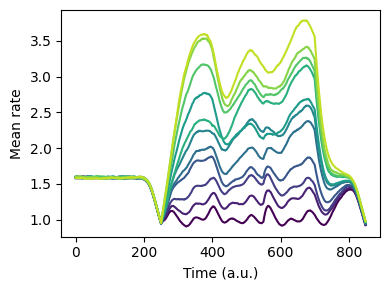

In [30]:
fig, ax = plt.subplots(1, sharey='all', sharex='all', figsize=(4, 3))
# for i in range(ax.shape[1]):
#     ax[-1,i].set(xlabel='Time (a.u.)')
cmap = colormaps.get_cmap('viridis')
for i, (pm, test) in enumerate(zip(perturb_param, tests)):
    ax.plot(test[0][T_burn//2:T_burn+T_rend].mean(axis=1), c=cmap(i/len(perturb_param)))
    
ax.set(xlabel='Time (a.u.)', ylabel='Mean rate')
fig.tight_layout()

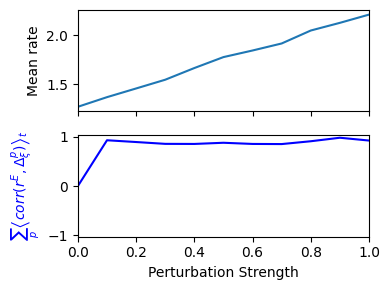

In [31]:
fig, ax = plt.subplots(2, sharex='all', figsize=(4, 3))
# ax = [*ax, ax[1].twinx()]
ax[0].plot(perturb_param, list(map(lambda x: x[0].mean(), tests)))
ax[1].plot(perturb_param, list(map(lambda x: x[T_burn:].sum(axis=1).mean(), corrs)), 
           color='b', label='Corr.')
# ax[2].plot(perturb_param, list(map(lambda x: x.mean(), ovlps)), 
#            color='r', label='Overlap')
ax[0].set(ylabel='Mean rate')
_ = np.abs(ax[1].get_ylim()).max()
ax[1].set(xlabel='Perturbation Strength', xlim=perturb_param[[0,-1]], ylim=[-_, _])
ax[1].set_ylabel(r'$\sum_p\left\langle corr(r^E, \Delta_\xi^p)\right\rangle_t$', c='b')
# ax[2].set_ylabel(r'$\left\langle r^E \cdot \xi^p\right\rangle_{t,p}$', c='r')
fig.tight_layout()